# SEP Distribution Tool

This tool downloads SEP intensity-time series data from various different spacecraft and visualizes the SEP distribution using Gaussian curves in one final results plot.

It will provide a Gaussian curve fitted to the intensity as a function of the observers' longitude at the Sun at each time step (as seen in the figure below), and result in a single timeseries plot to show the evolution of the calculated center and width of the particles distribution.
<div>
    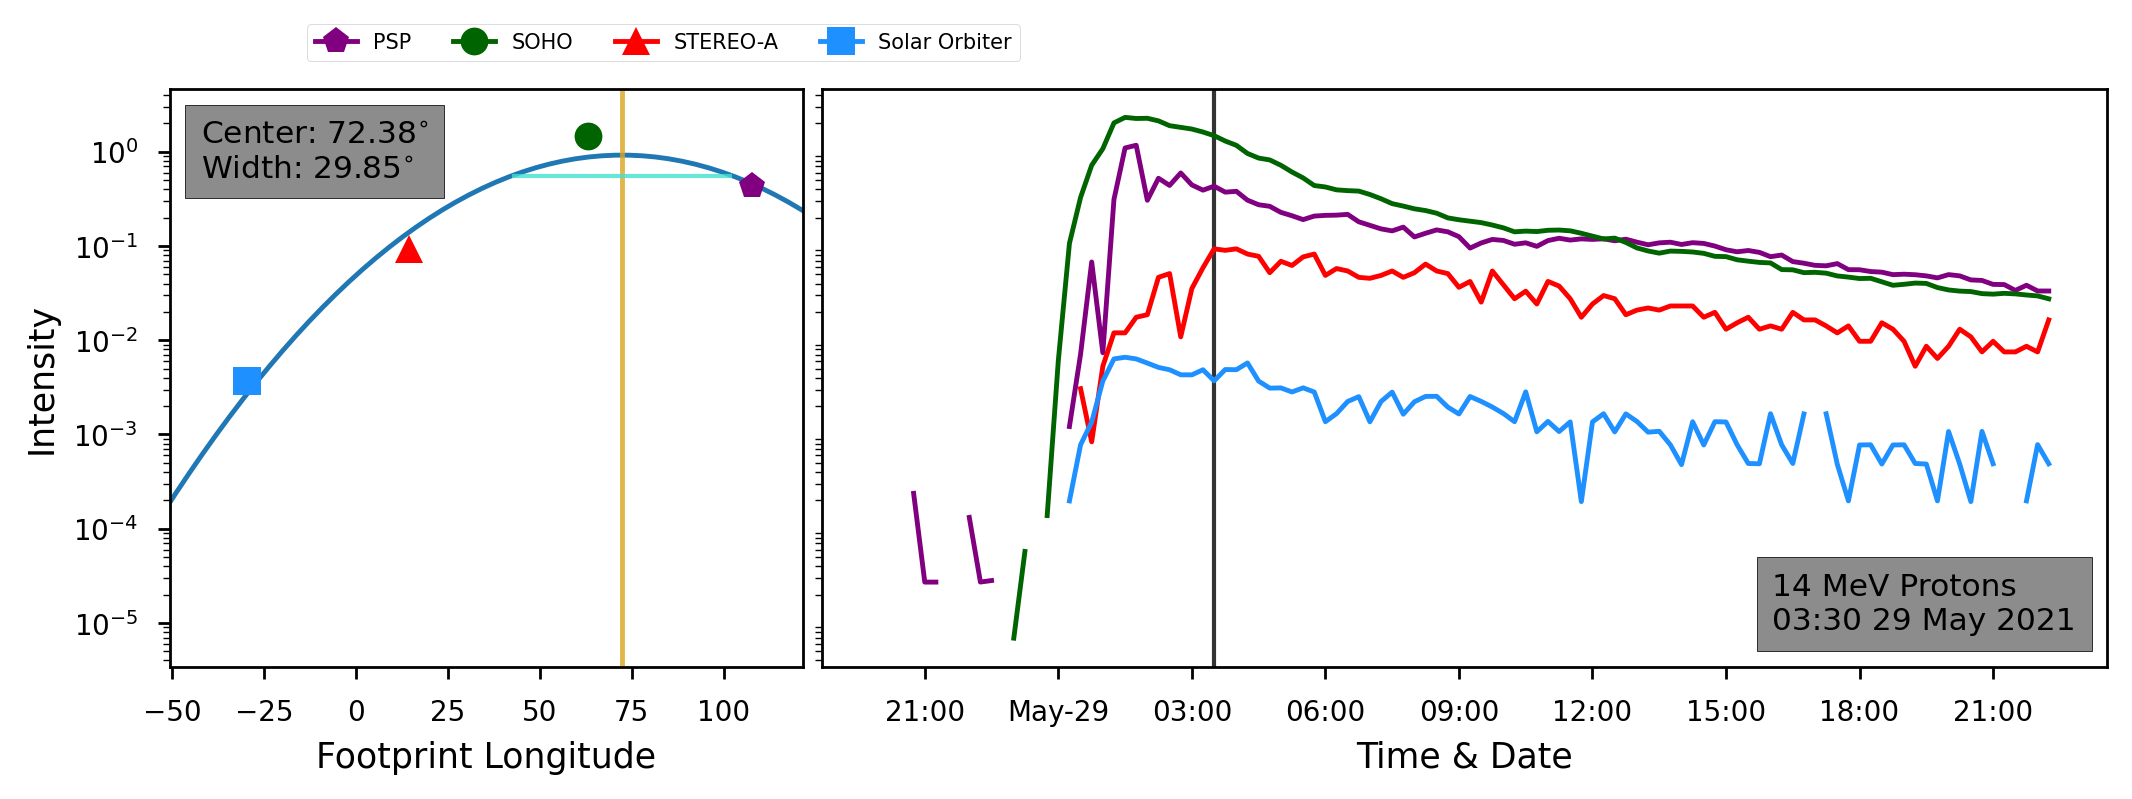
</div>

<div class="alert alert-block alert-info">
<b>Important:</b> This tool is made for comparing observations of more than 3 spacecraft, each at unique locations. For that, it works with <i>PSP, SOHO, Solar Orbiter, and STEREO-A<i/> only. 
</div>

## Table of Contents
1. [Load the event](#Load-the-event)
2. [Background Subtraction](#Background-Subtraction)
3. [Instrument Intercalibration](#Instrument-Intercalibration)
4. [Radial Scaling](#Radial-Scaling)
5. [Peak Fits](#Peak-Fits)
6. [Gaussian Fits](#Gaussian-Fits)
7. [Final Results](#Final-Results)
- [Appendix](#Appendix)
- [Glossary](#Glossary)

In [1]:
# Import modules
import os
import datetime as dt
import numpy as np
import pandas as pd

from spatial_analysis import SpatialEvent as sp_event

## Load the event
[Return to top](#Table-of-Contents)

Collect the event start and end dates (specifying the start at / near the observed flare onset time), and the eruption location (in Stonyhurst).

In [2]:
# Options
event_options = {'28May2021': {'date': "2021/05/28 22:19:00",
                               'reference': [67, 18]}, #longitude, latitude
                 '28Oct2021': {'date': "2021/10/28 15:17:00",
                               'reference': [1, -28]},
                 '14Mar2022': {'date': "2022/03/14  15:00:00", 
                               'reference': [110, -23]},
                 '21Mar2022': {'date': "2022/03/21  02:00:00", 
                               'reference': [137, -35]},
                 '16May2023': {'date': "2023/05/16  15:00:00", 
                               'reference': [np.nan, np.nan]},
                 '29Jan2024': {'date': "2024/01/29 03:54:00",
                               'reference': [86, 28]},
                 '23Mar2024': {'date': "2024/03/23 00:58:00",
                               'reference': [-7, 20]},
                 '01Sep2024': {'date': "2024/09/01 14:44:00",
                               'reference': [np.nan, np.nan]}
                }

startdate = dt.datetime.strptime(event_options['28May2021']['date'], "%Y/%m/%d %H:%M:%S")
enddate = startdate + pd.Timedelta(days=1, hours=12)

source_location = event_options['28May2021']['reference'] 


In [3]:
# Set your local path where you want to save the output and raw data files. 
out_path = f"{os.getcwd()}{os.sep}SEP_Distribution/" # For the figures
data_path = f"{os.getcwd()}{os.sep}data/" # For the raw cdf 

### Show the fleet distribution

A quickview of the observers distribution for the event and setting up the event class.

For more information on the Solar-MACH tool, see: [the Online Tool](https://solar-mach.github.io/) and the links within.

NB: BepiColombo data will be included in future versions, but unfortunately it can't be included yet.

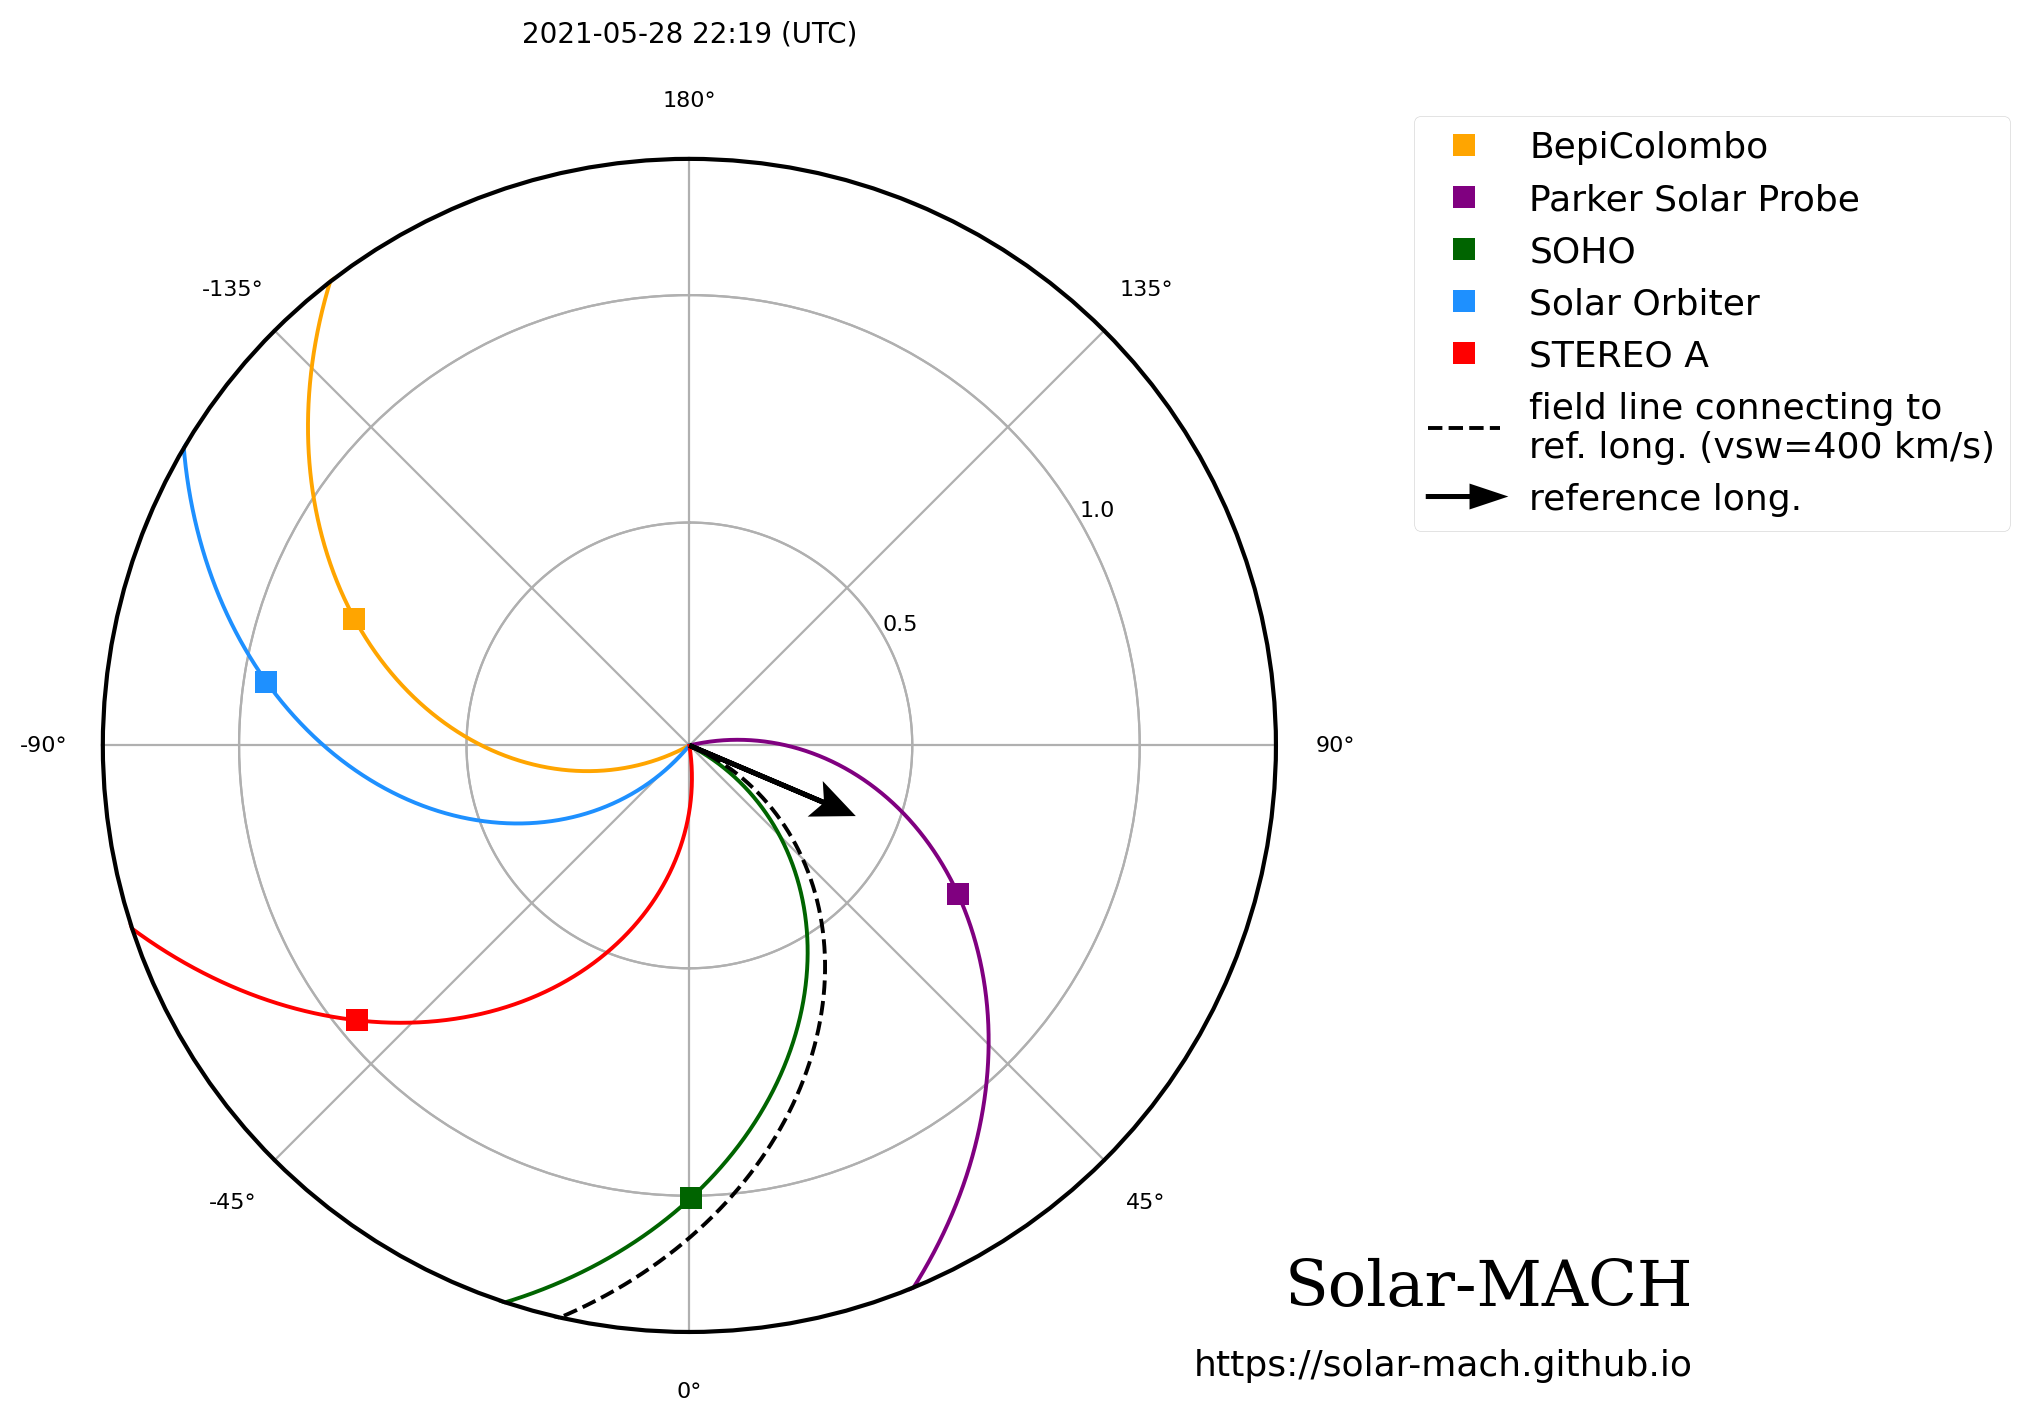

Spacecraft/Body  Stonyhurst longitude (°)  \
Spacecraft/Body                                             
BepiColombo         BepiColombo               -110.733366   
PSP                         PSP                 61.059695   
SOHO                       SOHO                  0.255711   
Solar Orbiter     Solar Orbiter                -98.578091   
STEREO-A               STEREO-A                -50.395401   

                 Stonyhurst latitude (°)  Heliocentric distance (AU)  \
Spacecraft/Body                                                        
BepiColombo                    -3.410311                    0.798805   
PSP                             3.108280                    0.685340   
SOHO                           -1.010817                    1.004046   
Solar Orbiter                  -0.943589                    0.950952   
STEREO-A                       -6.234611                    0.963644   

                 Longitudinal separation to Earth's longitude  \
Spacecraft/Body                                                 
BepiColombo                                       -110.733364   
PSP                                                 61.059698   
SOHO                                                 0.255714   
Solar Orbiter                                      -98.578089   
STEREO-A                                           -50.395399   

                 Latitudinal separation to Earth's latitude  Vsw  \
Spacecraft/Body                                                    
BepiColombo                                       -2.373459  400   
PSP                                                4.145132  400   
SOHO                                               0.026034  400   
Solar Orbiter                                      0.093263  400   
STEREO-A                                          -5.197760  400   

                 Magnetic footpoint longitude (Stonyhurst)  \
Spacecraft/Body                                              
BepiColombo                                     -61.011138   
PSP                                             103.695701   
SOHO                                             62.969437   
Solar Orbiter                                   -39.194394   
STEREO-A                                          9.300427   

                 Longitudinal separation between body and reference_long  \
Spacecraft/Body                                                            
BepiColombo                                            -177.733366         
PSP                                                      -5.940305         
SOHO                                                    -66.744289         
Solar Orbiter                                          -165.578091         
STEREO-A                                               -117.395401         

                 Longitudinal separation between body's magnetic footpoint and reference_long  \
Spacecraft/Body                                                                                 
BepiColombo                                            -128.011138                              
PSP                                                      36.695701                              
SOHO                                                     -4.030563                              
Solar Orbiter                                          -106.194394                              
STEREO-A                                                -57.699573                              

                 Latitudinal separation between body and reference_lat  
Spacecraft/Body                                                         
BepiColombo                                             -21.410311      
PSP                                                     -14.891720      
SOHO                                                    -19.010817      
Solar Orbiter                                           -18.943589      
STEREO-A                                                -24.2346

In [4]:
# The solarmach tool can try to find the observed solar wind speeds (V_sw) for each observer.
# Or a default value can be provided here.
obs_vsw = 400 # None to load; otherwise provide a value to use for all.

may28 = sp_event(dates = [startdate, enddate], 
                 filepaths = [out_path, data_path], 
                 flare_loc = source_location,
                 V_sw = obs_vsw)

### Spacecraft options

Provide the spacecraft you want to use in this notebook (dictionary key), the proton energy channels for each instrument (dictionary value in list form), and the time interval you wish to use (resampling).

The default channels provided are for ~14 MeV protons.

More information about this step can be found in the [Appendix](#Appendix).

<div class="alert alert-block alert-warning">
<b>Notes for Nina:</b> Do we give them the list of all energy channels to be able to choose?
</div>

In [5]:
# ~14 MeV Proton channels
spacecraft_channels = {'PSP': [3,4],
                       'SOHO': [0],
                       'STEREO-A': [0],
                       'Solar Orbiter': [10,12]}

resampling = '15min'

<div class="alert alert-block alert-info">
<b>Note for user:</b> This step can take a while. Feel free to refresh your coffee while you wait.
</div>

In [6]:
may28.load_spacecraft_data(channels = spacecraft_channels, # Both must be provided
                           resampling = resampling) 

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

psp_isois-epihi_l2-het-rates60_20210530_v24.cdf:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

/home/jaxl/Desktop/SOLER_SEPdistributiontool/spatial_analysis.py:699: RuntimeWarning: Mean of empty slice
  flux_arr.append( np.nanmean([psp_df.loc[tt, f"A_F_{bin_label}"], psp_df.loc[tt, f"B_F_{bin_label}"]]) )
/home/jaxl/Desktop/SOLER_SEPdistributiontool/spatial_analysis.py:700: RuntimeWarning: Mean of empty slice
  unc_arr.append( np.nanmean([psp_df.loc[tt, f"A_Func_{bin_label}"], psp_df.loc[tt, f"B_Func_{bin_label}"]]) )
/home/jaxl/Desktop/SOLER_SEPdistributiontool/spatial_analysis.py:622: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(np.sum(x_arr**2)) / len(x_arr)


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

soho_erne-hed_l2-1min_20210530_v01.cdf:   0%|          | 0.00/279k [00:00<?, ?B/s]

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

sta_l1_het_20210530_v01.cdf:   0%|          | 0.00/215k [00:00<?, ?B/s]

solo_L2_epd-het-asun-rates_20210530_V01.cdf: 606kB [00:00, 934kB/s]                                                               
solo_L2_epd-het-north-rates_20210530_V01.cdf: 598kB [00:00, 941kB/s]                                                              
solo_L2_epd-het-south-rates_20210530_V01.cdf: 606kB [00:00, 934kB/s]                                                              
solo_L2_epd-het-sun-rates_20210530_V01.cdf: 606kB [00:00, 1.17MB/s]                                                               


Data loading complete.


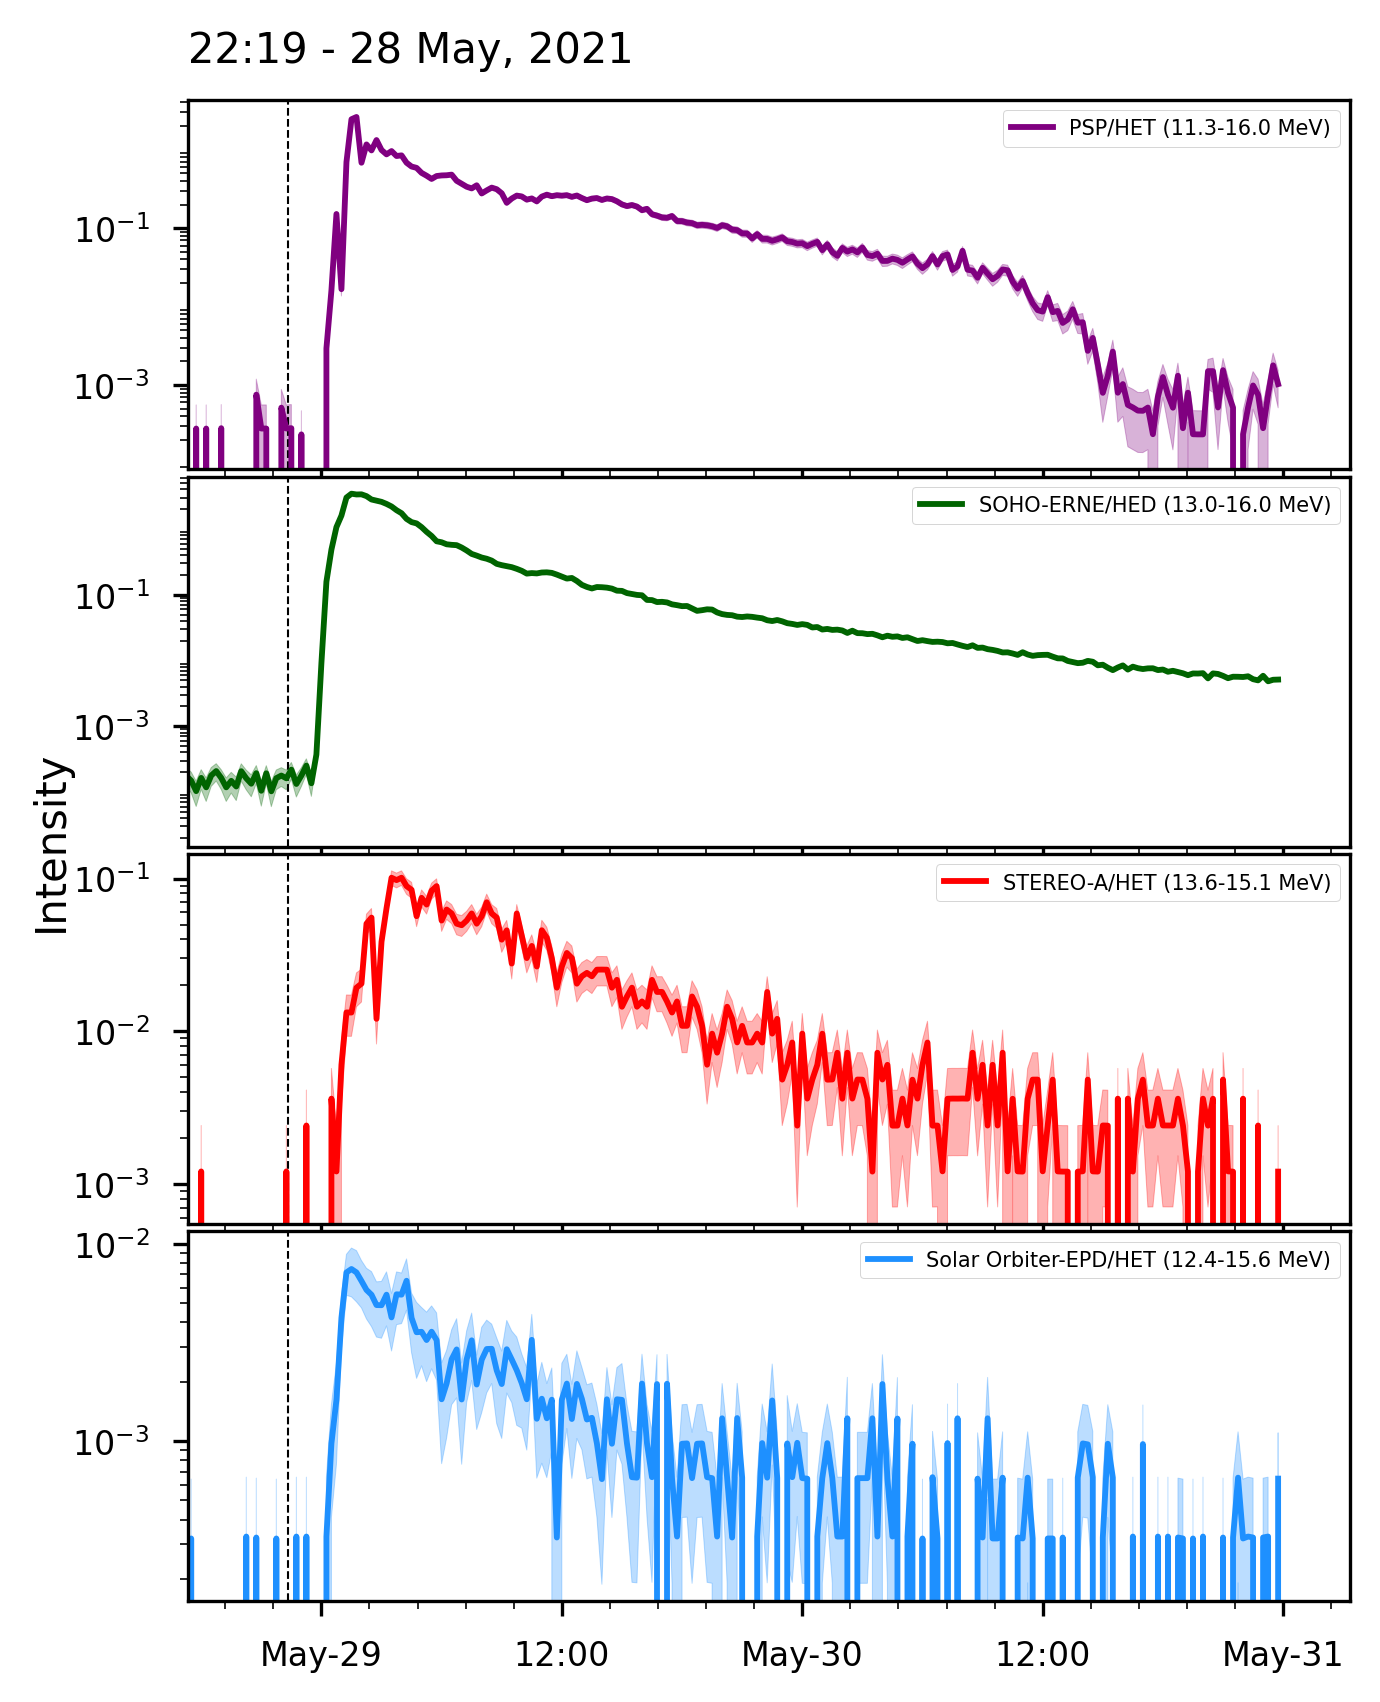

In [7]:
may28.plot_intensities()

## Background Subtraction
[Return to top](#Table-of-Contents)

Using a window period provided by the user, the tool calculates the average background and subtracts the intensity data by this average. 

This step allows you to confirm the background window before running the function to adjust the data.

More information about this step can be found in the [Appendix](#Appendix).

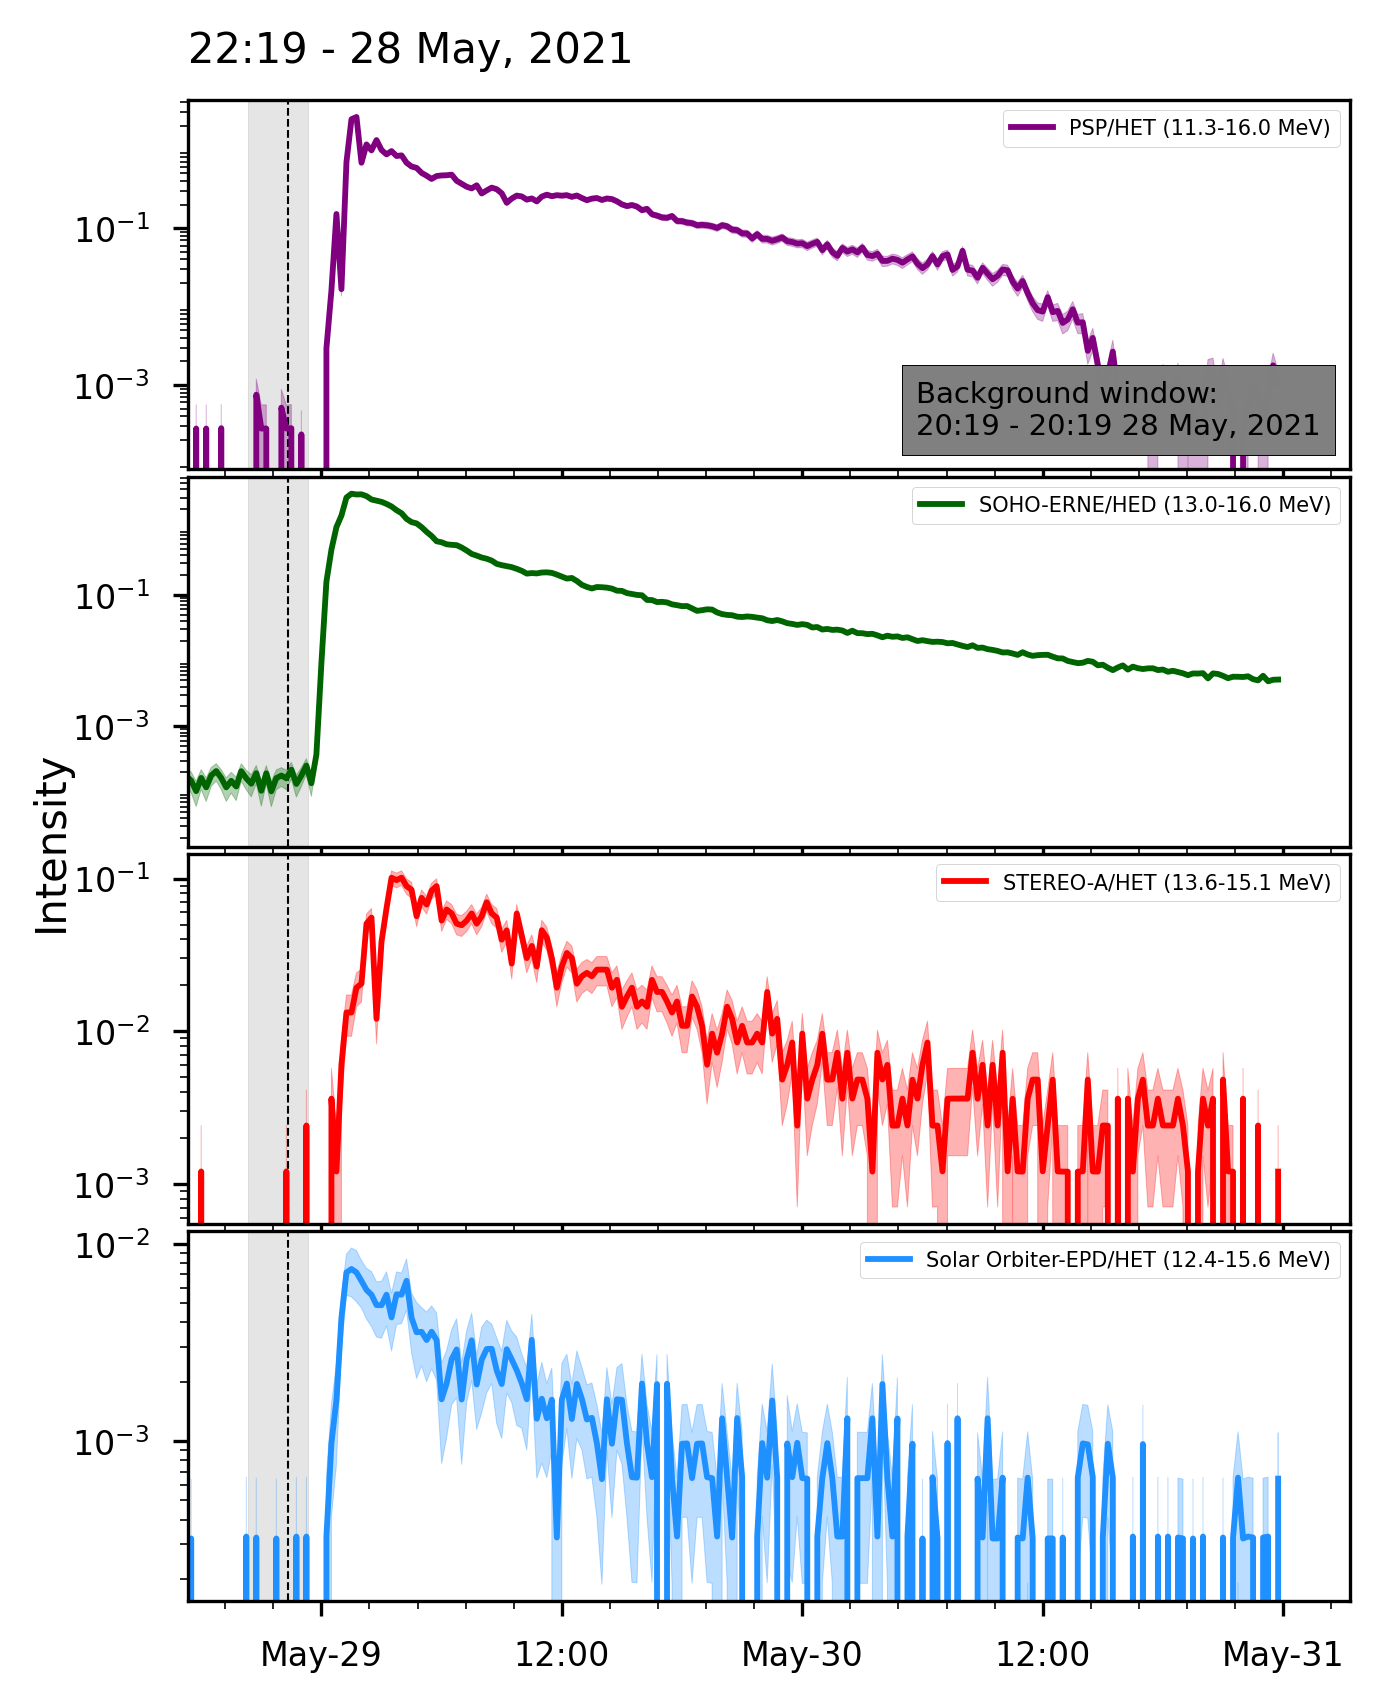

In [8]:
process_background_subtraction = True

if process_background_subtraction:
    # User input on background
    background_window = [startdate - dt.timedelta(hours=2), 
                         startdate + dt.timedelta(hours=1)]
    
    # User can check the window
    may28.plot_intensities(background_window = background_window)
else:
    background_window = []

In [9]:
# Perform the Background subtraction
may28.background_subtract(background_window = background_window, 
                          perform_process = process_background_subtraction)


Background subtraction function complete.


## Instrument Intercalibration
[Return to top](#Table-of-Contents)

This method adjusts the intensity data so as to calibrate each instrument to one common baseline. In this work, STEREO-A HET is the baseline and the only instrument that we have found (for this energy range and species) that requires an intercalibration factor is SOHO-ERNE/HED (see [Richardson et al. 2014](https://link.springer.com/article/10.1007/s11207-014-0524-8) for more information).

More information about this step can be found in the [Appendix](#Appendix).

In [11]:
process_intercalibration = True

ic_values = {'PSP':1, 
             'SOHO':0.67, 
             'STEREO-A':1, 
             'Solar Orbiter':1}

may28.intercalibrate(intercalibration_factors = ic_values, 
                     perform_process = process_intercalibration)

Intercalibration function complete.


## Radial Scaling
[Return to top](#Table-of-Contents)

This method adjusts the intensity data to 1~au from whatever radial distance the spacecraft is measuring at according to: $$I_{1 au} = I \cdot R^{a\pm b}$$

The required values are in the form of `radscaling_values = [a, b]`, with $(a\pm b)=(2.14 \pm 0.26)$ from [Lario et al. (2006)](https://iopscience.iop.org/article/10.1086/508982).

More information about this step can be found in the [Appendix](#Appendix).

<div class="alert alert-block alert-info">
<b>Note for user:</b> This step can also take a while. Feel free to check your emails while you wait.
</div>

In [14]:
process_radial_scaling = True

radscaling_values = [2.14, 0.26] # Values must be provided

may28.radial_scale(radial_scaling_factors = radscaling_values, 
                   perform_process = process_radial_scaling)

The positional data is already downloaded, would you like to use this data? 


yes or no y


SolarMACH data loaded for full time range.
Radial Scaling function complete.


In [16]:
may28.save_df_to_csv(label='_final')

## Peak Fits
[Return to top](#Table-of-Contents)

Plot the fitted Gaussian to the peak intensity as a function of the footprint longitude of the spacecraft at the time of the peak.

<br>

`window_length`: Provide an estimate for how many hours can pass where the peak intensity might occur.
The window to consider the peak will then be considered between the given start time and (for e.g.) 5 hours later.

If nothing is provided, the function uses a default value of 10 hours.

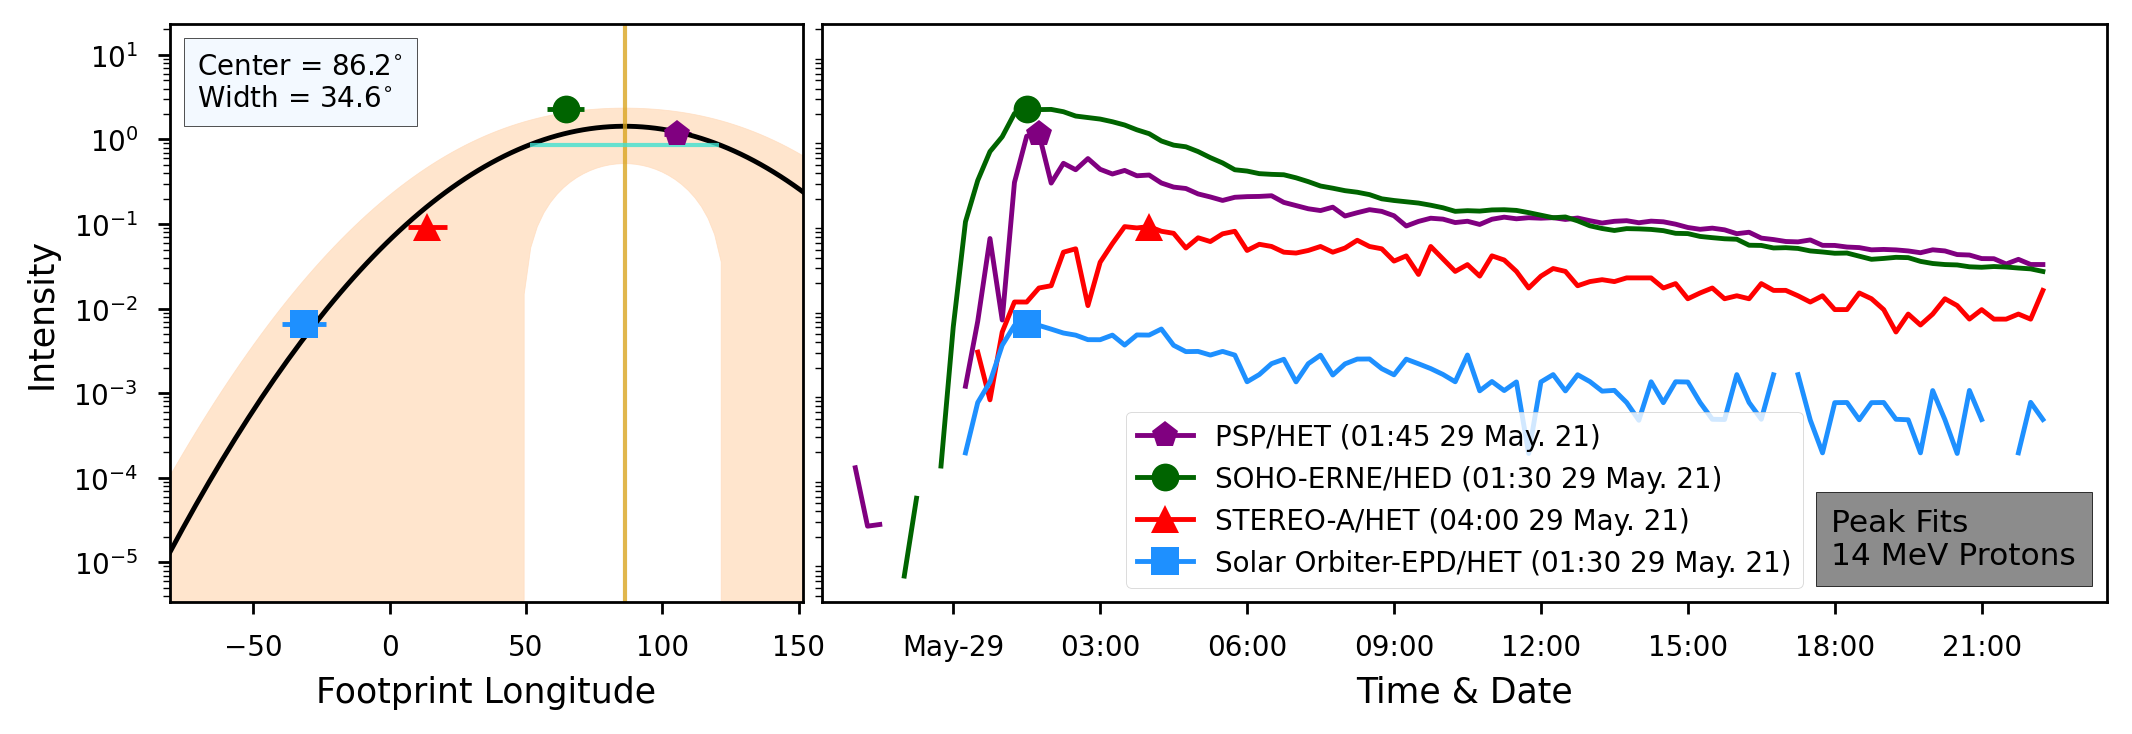

In [17]:
may28.plot_peak_fits(window_length = 10)

## Gaussian Fits
[Return to top](#Table-of-Contents)

A Gaussian curve is fitted to the observed intensities as a function of the observers footprint longitude at each time step.

More information about this step can be found in the [Appendix](#Appendix).

  0%|          | 0/288 [00:00<?, ?it/s]

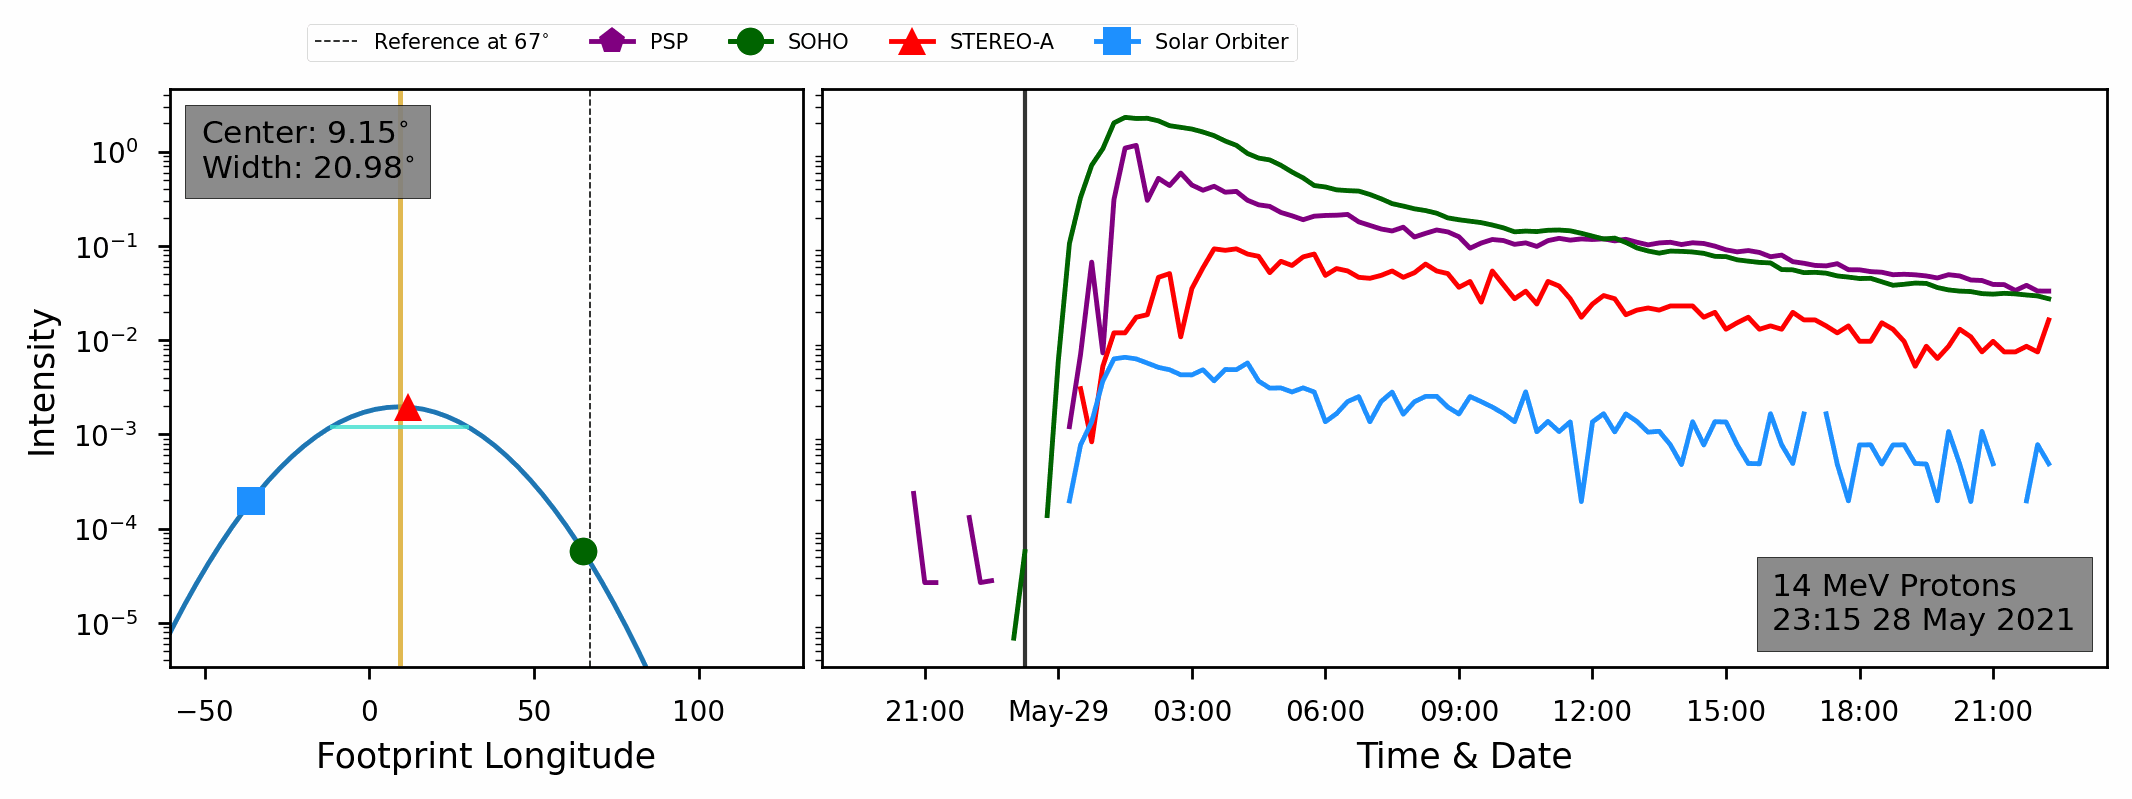

In [18]:
may28.calc_Gaussian_fit()

## Final Results
[Return to top](#Table-of-Contents)

This plot will show the particle intensities in units of (sr. s. cm$^2$. MeV)$^{-1}$, and the Gaussian results in degrees. The Gaussian center ($X_0$) plots the longitude of the center of the particle distribution backmapped to its footprint on the Sun.

<div class="alert alert-block alert-warning">
<b>Notes for Jan:</b> can we return the figure plot to do changes with? If there are decent results (say all center values are ~80 degrees), and one or two outliers (just these two values are >1000 degrees) then the user can adjust the limits to better see what is happening with the bulk of the results.
</div>

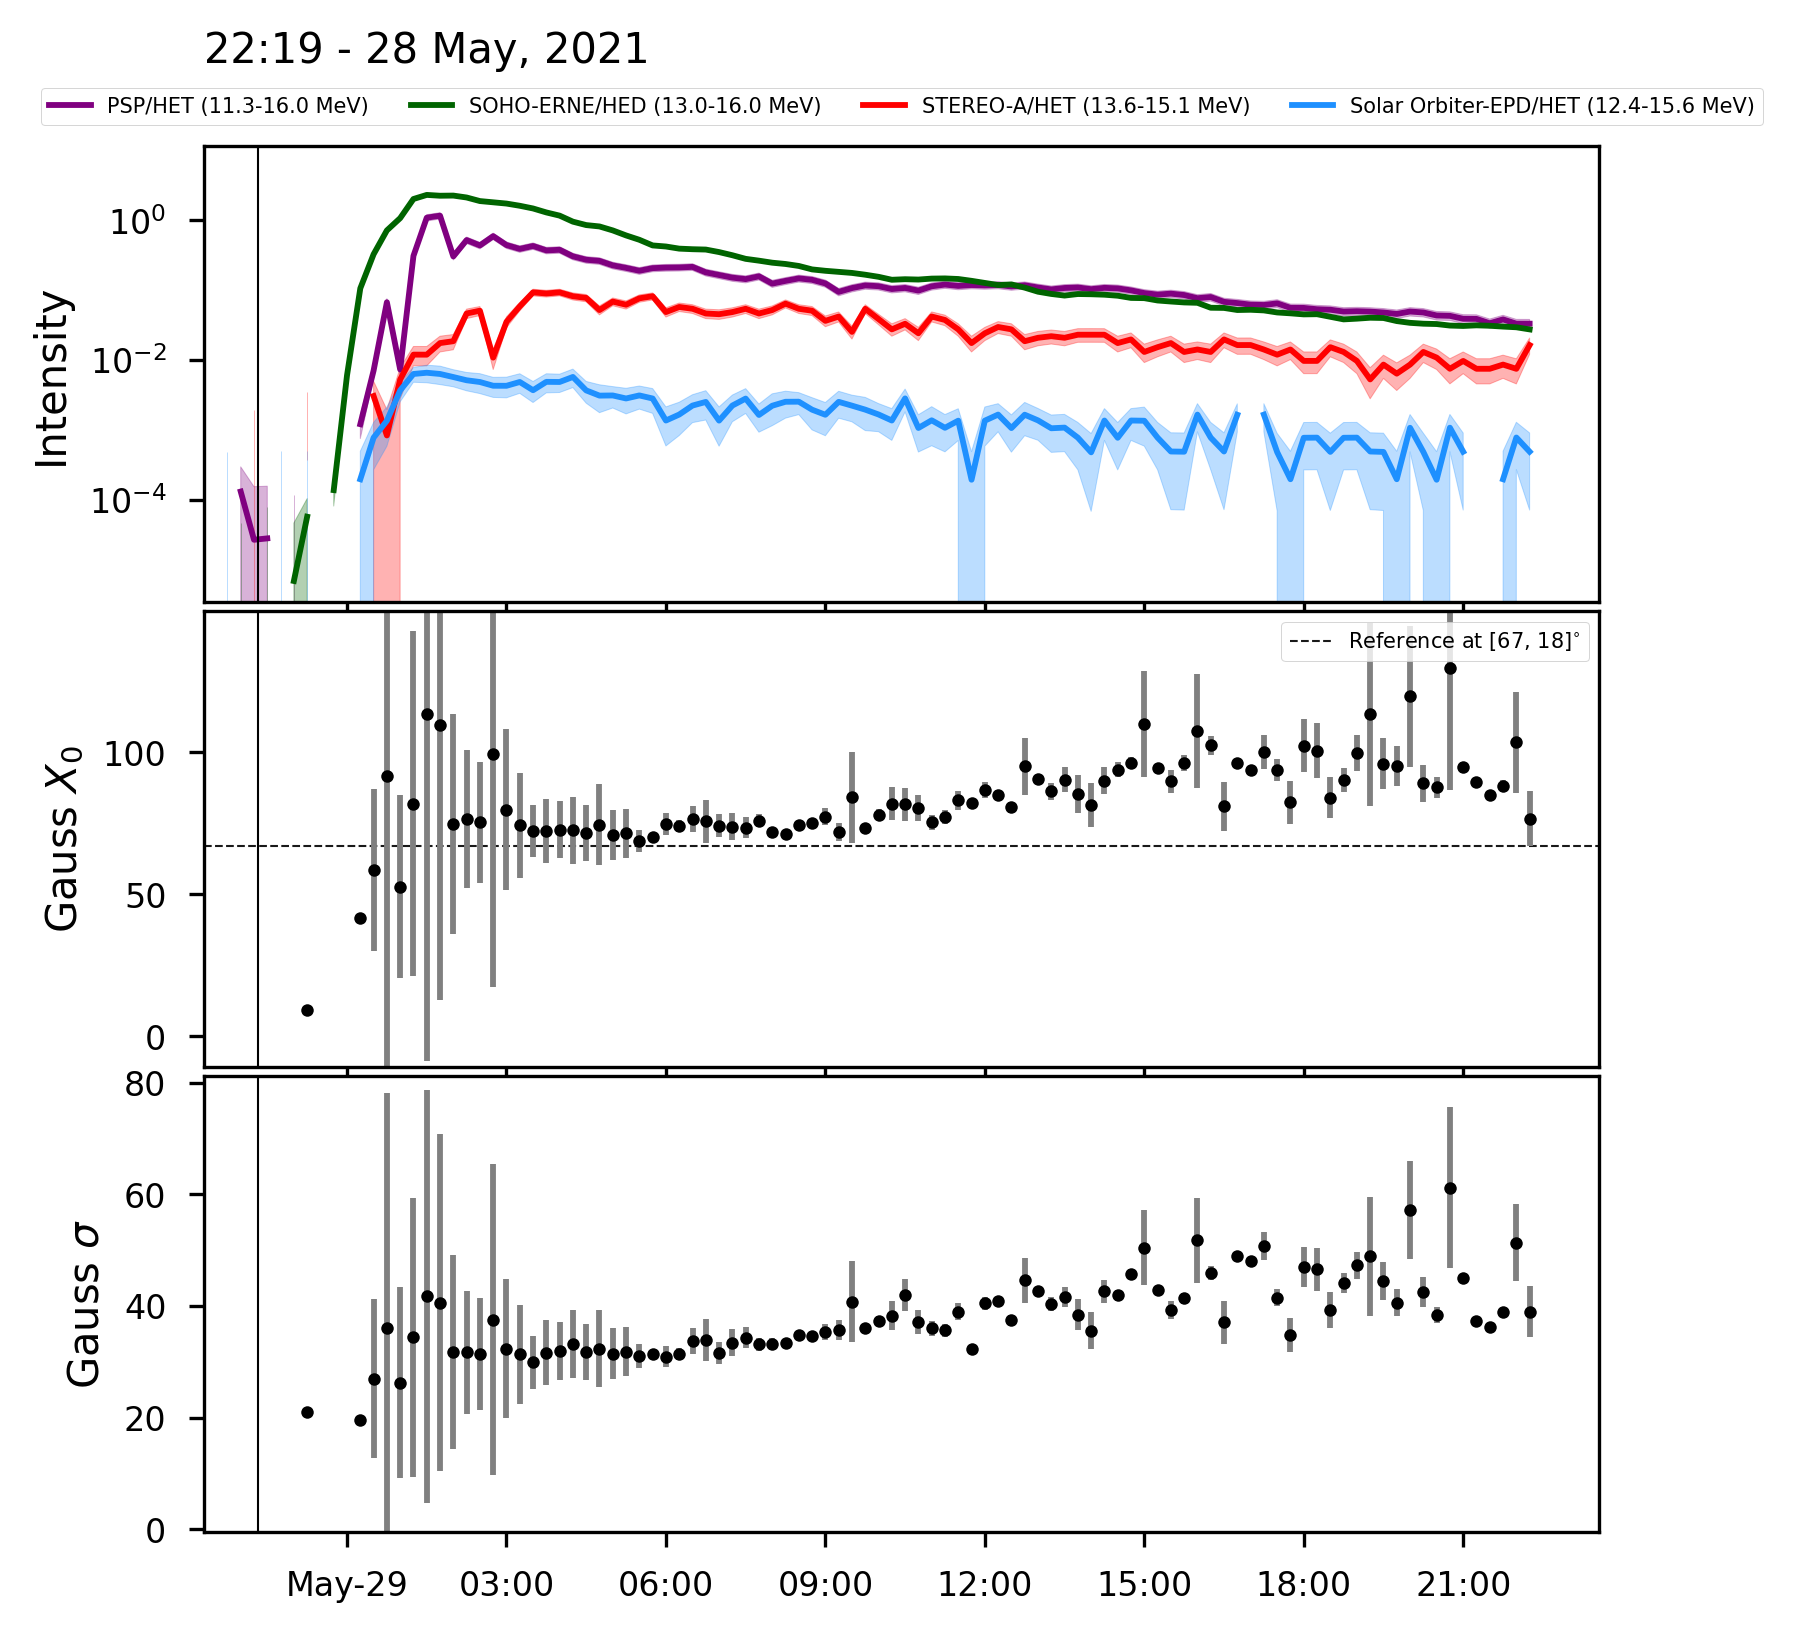

In [19]:
may28.plot_Gauss_results()

# Appendix
[Return to top](#Table-of-Contents)

__Load the data__ \
In this method, we are downloading the spacecraft's positional data using SolarMACH and the intensity (and intensity uncertainty) data for the given proton energy channels (in this notebook the range is approximately 11-16 MeV).

For instruments with multiple viewing directions, the directions are averaged to provide omni-directional data, and for instruments with only one viewing direction (SOHO; STEREO-A-HET) we simply take the data as is.

If a range of channels is provided then they are merged using a weighted sum method, before averaging the data to 15-minute intervals (resampling).
***

__Background Subtraction__ \
Calculates the average intensity value of the background time period and reduces the full dataset by this value.
***

__Intercalibration__ \
This method adjusts the intensity data so as to calibrate each instrument to one common baseline. In this work, STEREO-A HET is the baseline and the only instrument that we have found (for this energy range and species) that requires an intercalibration factor is SOHO-ERNE/HED (see [Richardson et al. 2014](https://link.springer.com/article/10.1007/s11207-014-0524-8) for more information).

The data is adjusted using: $I_{new} = I_{old} \cdot IC$ where $IC$ is the intercalibration factor.
***

__Radial Scaling__ \
Using the values presented in [Farwa, et al. (2025)](https://www.aanda.org/articles/aa/abs/2025/01/aa50945-24/aa50945-24.html), which used values for 4-13 MeV and 27-37 MeV protons from [Lario et al. (2006)](https://iopscience.iop.org/article/10.1086/508982).

The scaled intensity is calculated as $I_{1 au} = I \cdot R^{a\pm b}$, where $R$ is the radial distance, $I$ is the original intensity, and (for protons specifically) the scaling factors are given as $a \pm b = 2.14 \pm 0.26$ (or for 27-37 MeV protons: $a \pm b = 1.97 \pm 0.27$).

To calculate the scaled uncertainty, we use the following procedure:
1. Calculate the boundary limits for the intensity calculation (e.g. $I_+ = I\cdot R^{a+b}$; $I_- = I\cdot R^{a-b}$; Therefore, $\Delta I_+ = |I_{1 au}-I_+|$ and $\Delta I_- = |I_{1 au}-I_-|$ are the limits.
2. Find the higher boundary limit, as long as it is < the nominal value ($I_{1 au}$).
3. Calculate the scaled uncertainty value: $\Delta I_{1 au} = \Delta I \cdot R^a$.
4. Combine both to get a final uncertainty value: $\Delta I_{1 au, final} = \sqrt{(max[\Delta I_-, \Delta I_+])^2 + (\Delta I_{1 au})^2}$.

NB: Check that this final uncertainty is still less than the intensity value!
***

__Gaussian Curve Fitting__\
To calculate the Gaussian curve we use $f = A \cdot \exp\left[ \frac{-(x - X_0)^2}{2 \sigma^2} \right]$ where $A$ is the height of the curve, $X_0$ is the center of the curve, and $\sigma$ is the 'width' of the curve. In order to plot these values on the curve (i.e. straight lines at the center etc) the sigma value is plotted with `y = (0.6065) 10^{A}`, `xmin = X_0 - sigma`, and `xmax = X_0 + sigma`.

The logarithmic Gaussian curve is calculated with the same variables using $f = \log A - \frac{(x - X_0)^2}{2 \ln(10) \sigma^2}.$

The example in the figure uses the following parameters: $A=100, X_0=50,$ and $\sigma=20$.

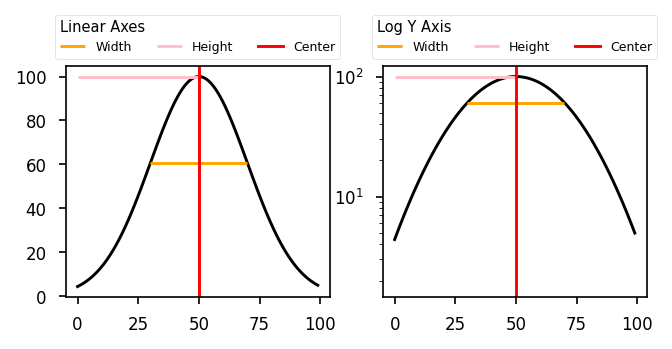
***

## Glossary
[Return to top](#Table-of-Contents)

- `*.load_spacecraft_data(channels={...}, resampling='...')`
  Downloads and stores the relevant observed data for the tool to use. The list of spacecraft is taken from the keys of the dictionary passed to `channels`.
- `*.background_subtract(background_window=[...], perform_process=True)`
  Calculates the average background and subtracts that value from the rest of the observed data. The background is defined in the array that is passed (i.e. \[start, end\]). To opt out of the process and continue without background subtracting, the boolean `perform_process` can be set to false, but the function must still run to continue with the tool.
- `*.intercalibrate(intercalibration_factors={...}, perform_process=True)`
  Adjusts the observed data by the factors provided in the dictionary. To opt out of the process and continue without intercalibrating, the boolean `perform_process` can be set to false, but the function must still run to continue with the tool.
- `*.radial_scale(radial_scaling_factors=[...], perform_process=True)`
  Adjusts the observed data based on the values provided in the array and the observers radial distance. To opt out of the process and continue without radially scaling, the boolean `perform_process` can be set to false, but the function must still run to continue with the tool.

***

- `*.plot_peak_fits(window_length=10)`
  Calculates and plots the peak intensity values of each observer and the fitted Gaussian curve, alongside the intensity time-series. The window to determine the peaks can be provided in the form of _hours after the start of the event_, the default value is 10 hours after the event start.
- `*.calc_Gaussian_fit()`
  Calculates and plots the intensity as a function of longitudinal position of each observer and the fitted Gaussian curve, alongside the intensity time-series for each time interval. A gif of all the time steps is produced at the end.

***

- `*.get_spacecraft_list()`
  Returns the list of spacecraft included in the current run of the tool
- `*.get_sc_df('sc')`
  Returns the data for the given spacecraft (`sc`) or if provided `'Gauss'` then it will return the results of fitting the Gaussian curve.
- `*.get_peak_data()`
  Returns the data and results for fitting the peak intensity data.
- `*.save_df_to_csv()`
  Saves the observed data into a multi-indexed csv file for use outside of the tool.

***
  
- `*.plot_intensities()`
  Plots the intensity time series of all the provided spacecraft. Can also pass the keyword argument: `background_window=[start, end]` with start and end dates to provide a highlighted region in the plot.
- `*.plot_Gauss_results()`
  Plots the time profiles for the intensity, Gaussian center, and Gaussian width, respectively. This is the final result for this tool.